# Assignment 1

**Course** CS-867 Computer Vision

**Instructor:** Dr. Muhammad Moazam Fraz

**Submitted By:** Sarfraz Ahmad

**CMS ID:** 363320


## Importing Libraries

In [2]:
import os
import random
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from cv2 import HOGDescriptor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, cross_validate, cross_val_score, StratifiedShuffleSplit

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load and View Images

In [3]:
folders = os.listdir("CS67_Fall2022_ A1_Dataset")
if ".DS_Store" in folders:
    folders.remove(".DS_Store")

folders = sorted(folders, key=int)

data_type = ["train", "test"] # txt Files in Dataset folders
df_list = [] # List that will contain the dataframe dict

# In each folder there are 2 txt files, train.txt and test.txt
# train.txt files from each folder are taken and image names in these files are stored as filename in dict
# Same procedure is then followed for test.txt files
for i in data_type: 
    for j in folders:
        with open(f"CS67_Fall2022_ A1_Dataset/{j}/{i}.txt") as f:
            for line in f:
                df_dict = {}
                df_dict["folder"] = j 
                df_dict["filename"] = line
                df_dict["file_type"] = i    # Train or Test
                df_dict["file_path"] = f"CS67_Fall2022_ A1_Dataset/{j}/{line}".strip()
                df_dict["label"] = int(j)   # Integer Label
                df_list.append(df_dict)

df = pd.DataFrame.from_dict(df_list)
df.head(10)

,folder,filename,file_type,file_path,label
0,00001,00468_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00468_00002.ppm,1
1,00001,00475_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00000.ppm,1
2,00001,00475_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00001.ppm,1
3,00001,00475_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00002.ppm,1
4,00001,00801_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00000.ppm,1
5,00001,00801_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00001.ppm,1
6,00001,00801_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00002.ppm,1
7,00001,00806_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00000.ppm,1
8,00001,00806_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00001.ppm,1
9,00001,00806_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00002.ppm,1


In [4]:
# Initialize lists to store train and test images
X_train = []
y_train = []
X_test = []
y_test = []

# iterate over the dataframe rows. For each row check type of file that whether it is train or test.
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row.file_type == "train":
        img = cv2.imread(row.file_path) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_train.append(img) # Append the loaded image in training data list 
        y_train.append(row.label)
    else:
        img = cv2.imread(row.file_path) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_test.append(img) # Append the loaded image in test data list
        y_test.append(row.label)

# Convert train and test data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Training Set Shape: ", X_train.shape)
print("Test Set Shape: ", X_test.shape)

100%|██████████| 1000/1000 [00:00<00:00, 2874.27it/s]

Training Set Shape:  (800, 128, 128)
Test Set Shape:  (200, 128, 128)


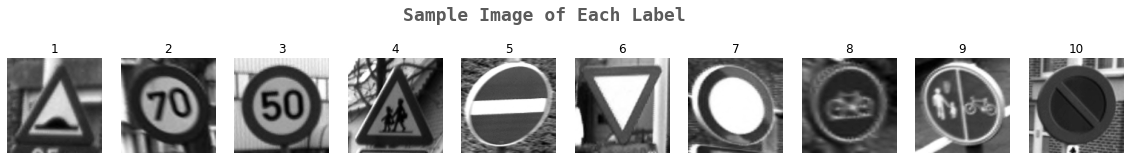

In [5]:
# Visiualize 1 image from each of the class

k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j], 'gray')
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

## Hog Descriptor

In [6]:
# Initialization of Hog Descriptor
winSize = (128,128)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (16,16)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64

signedGradients = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,
cellSize,nbins,derivAperture,
winSigma,histogramNormType,L2HysThreshold,
gammaCorrection,nlevels, signedGradients)

In [7]:
# Initialize lists that will store train and test hog descriptors
train_hg_desc = []
test_hg_desc = []

for i in data_type: # This for loop will handle iterate over "train" amd "test" and will handle X_train and X_test 
    if i=="train":
        for img in X_train:
            descriptor = hog.compute(img)   # Hog descriptor for each training image
            train_hg_desc.append(descriptor)
    else:
        for img in X_test:
            descriptor = hog.compute(img)   # Hog descriptor for each test image
            test_hg_desc.append(descriptor)

## Machine Learning Classifiers

### SVM

In [11]:
def SVM(X,Y,x,y):
  # Define parameter grid for Grid Search
  param_grid = {'C': [0.1, 1, 10, 100],
               'kernel': ['poly', 'rbf', 'sigmoid']} 
    
  svm=SVC(random_state=42)  # SVM model initialization
  svm_cv = GridSearchCV(svm, param_grid, scoring='accuracy')  
    
  # fitting the model for grid search
  svm_cv.fit(X,Y)
  svm=svm_cv.best_estimator_  # Best model parameters are stored
  print ('Best accuracy and parameters are: ', svm_cv.best_score_, svm_cv.best_params_)

  print('\n Test Results \n')
  y_p=svm_cv.best_estimator_.predict(x)

  x_axis_labels = sorted(np.unique(Y)) # labels for x-axis
  y_axis_labels = sorted(np.unique(Y)) # labels for y-axis
  
  sns.heatmap(confusion_matrix(y, y_p), annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  print(classification_report(y, y_p))

  return y_p

#### Quantitative Results

Best accuracy and parameters are:  0.9974999999999999 {'C': 0.1, 'kernel': 'poly'}

 Test Results 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



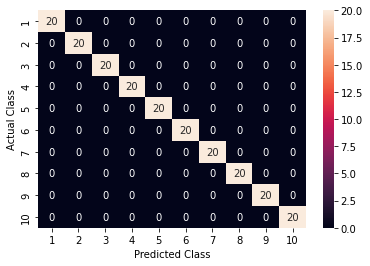

In [12]:
y_pred = SVM(train_hg_desc, y_train, test_hg_desc, y_test)

#### Qualitative Results

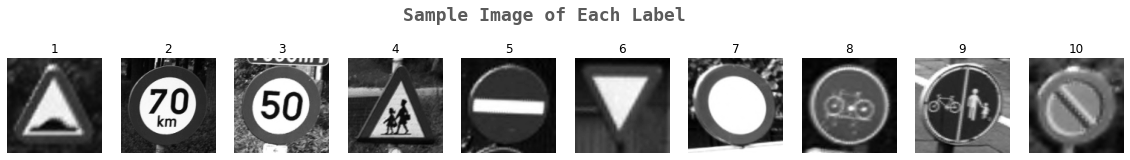

In [13]:
# Correctly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]==i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### Logistic Regression

In [15]:
def LRegression(X,Y,x,y):
  # Define parameter grid for Grid Search  
  param_grid = {"C":np.logspace(-3,3,7),
                'penalty':['l1','l2','elasticnet','none']}
  
  LR=LogisticRegression(random_state=42)  # Logistic Regression Initialization
  lr_cv = GridSearchCV(LR, param_grid, scoring='accuracy')
  
  # fitting the model for grid search
  lr_cv.fit(X, Y)
  lr=lr_cv.best_estimator_  # Best model parameters are stored
  print('Best accuracy and parameters are: ', lr_cv.best_score_, lr_cv.best_params_) 

  print('\n Test Results \n')
  y_p=lr_cv.best_estimator_.predict(x)

  x_axis_labels = sorted(np.unique(Y)) # labels for x-axis
  y_axis_labels = sorted(np.unique(Y)) # labels for y-axis
  sns.heatmap(confusion_matrix(y, y_p), annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  print(classification_report(y, y_p))

  return y_p

#### Quantitative Results

Best accuracy and parameters are:  1.0 {'C': 0.001, 'penalty': 'none'}

 Test Results 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



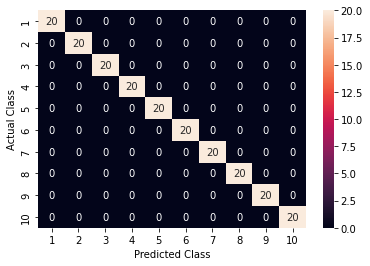

In [16]:
y_pred = LRegression(train_hg_desc, y_train, test_hg_desc, y_test)

#### Qualitative Results

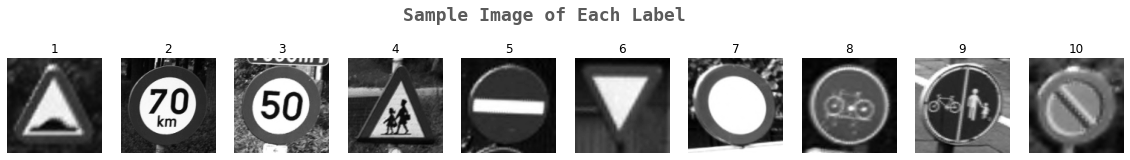

In [17]:
# Correctly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]==i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### Decision Tree

In [18]:
def Tree(X,Y,x,y):
  # Define parameter grid for Grid Search 
  param_grid = {'max_depth':range(2, 20), 
                'criterion':['gini', 'entropy']}

  DT=DecisionTreeClassifier(random_state=42)  # Decision Tree Initialization
  tree_cv = GridSearchCV(DT, param_grid, scoring='accuracy')
  
  # fitting the model for grid search
  tree_cv.fit(X, Y)
  tree=tree_cv.best_estimator_  # Best model parameters are stored
  print('Best accuracy and parameters are: ', tree_cv.best_score_, tree_cv.best_params_) 

  print('\n Test Results \n')
  y_p=tree_cv.best_estimator_.predict(x)

  x_axis_labels = sorted(np.unique(Y)) # labels for x-axis
  y_axis_labels = sorted(np.unique(Y)) # labels for y-axis
  sns.heatmap(confusion_matrix(y, y_p), annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  print(classification_report(y, y_p))

  return y_p

#### Quantitative Results

Best accuracy and parameters are:  0.91625 {'criterion': 'entropy', 'max_depth': 5}

 Test Results 

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        20
           2       1.00      1.00      1.00        20
           3       0.90      0.90      0.90        20
           4       1.00      0.90      0.95        20
           5       1.00      1.00      1.00        20
           6       0.91      1.00      0.95        20
           7       0.67      0.90      0.77        20
           8       0.89      0.85      0.87        20
           9       1.00      0.85      0.92        20
          10       0.84      0.80      0.82        20

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



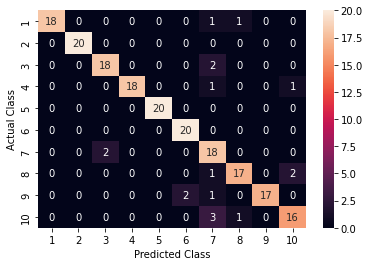

In [19]:
y_pred = Tree(train_hg_desc, y_train, test_hg_desc, y_test)

#### Qualitative Results

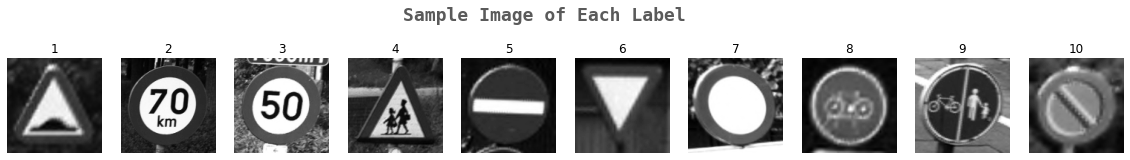

In [24]:
# Correctly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]==i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

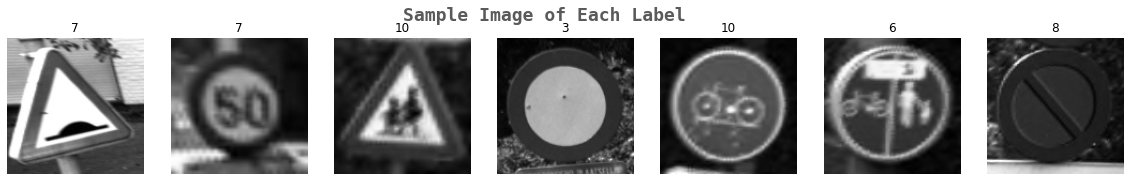

In [23]:
# Incorrectly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,7,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if j==200:
            break
        if y_test[j]==i and y_pred[j]!=i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### K Nearest Neighbors

In [27]:
def KNN(X,Y,x,y):
  #create a dictionary of all values we want to test for n_neighbors
  param_grid = {'n_neighbors': np.arange(1, 10),
                'metric': ['minkowski', 'euclidean', 'manhattan']}
  
  knn = KNeighborsClassifier()  # KNN Initialization
  knn_cv = GridSearchCV(knn, param_grid, scoring='accuracy') 
  
  # fitting the model for grid search
  knn_cv.fit(X, Y)
  knn = knn_cv.best_estimator_  # Best model parameters are stored
  print ('Best accuracy and parameters are: ', knn_cv.best_score_, knn_cv.best_params_) 

  print('\n Test Results \n')
  y_p=knn_cv.best_estimator_.predict(x) 

  x_axis_labels = sorted(np.unique(Y)) # labels for x-axis
  y_axis_labels = sorted(np.unique(Y)) # labels for y-axis
  sns.heatmap(confusion_matrix(y, y_p), annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  print(classification_report(y, y_p))

  return y_p

#### Quantitative Results

Best accuracy and parameters are:  0.99125 {'metric': 'minkowski', 'n_neighbors': 5}

 Test Results 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      0.95      0.97        20
           3       0.95      1.00      0.98        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



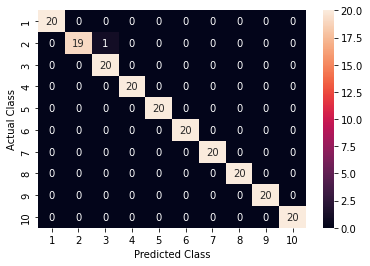

In [28]:
y_pred = KNN(train_hg_desc, y_train, test_hg_desc, y_test)

#### Qualitative Results

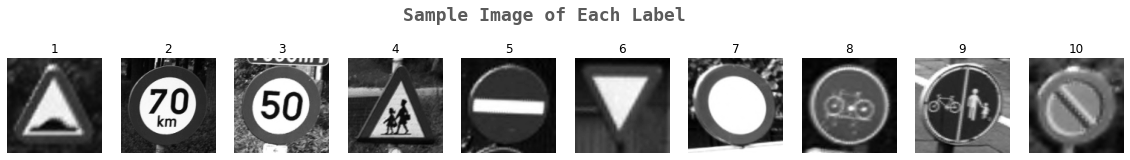

In [29]:
# Correctly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]==i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

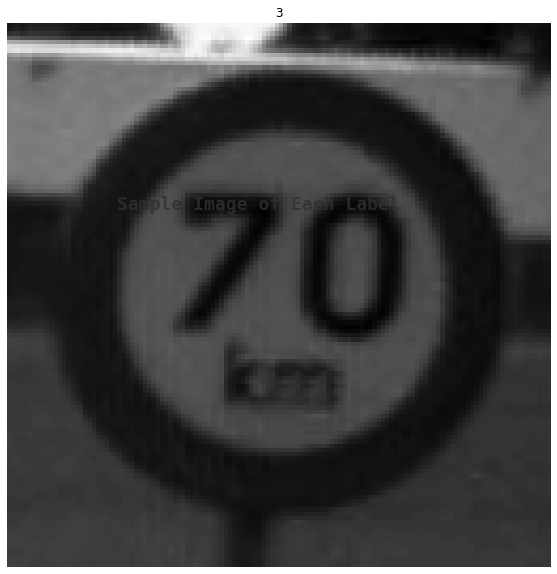

In [37]:
# Incorrectly Classified Test Images from each class
fig, ax = plt.subplots(1,1,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if j==200:
            break
        if y_test[j]==i and y_pred[j]!=i:
            ax.imshow(X_test[j], 'gray')
            ax.set_title(y_pred[j])
            ax.axis('off')
            break
        j+=1